In [1]:
import sys
sys.path.append('C:/Users/ustundag/Desktop/s2cnn_TORCH/')

# pylint: disable=E1101,R,C
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

from s2cnn import SO3Convolution
from s2cnn import S2Convolution
from s2cnn import so3_integrate
from s2cnn import so3_near_identity_grid
from s2cnn import s2_near_identity_grid

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class S2ConvNet(nn.Module):
    def __init__(self, b_in = 50):
        super(S2ConvNet, self).__init__()

        f1 = 20
        f2 = 40
        f_output = 10
        b_l1 = 10
        b_l2 = 6

        grid_s2  = s2_near_identity_grid()
        grid_so3 = so3_near_identity_grid()

        self.conv1 = S2Convolution (nfeature_in=3,  nfeature_out=f1, b_in=b_in, b_out=b_l1, grid=grid_s2)
        self.conv2 = SO3Convolution(nfeature_in=f1, nfeature_out=f2, b_in=b_l1, b_out=b_l2, grid=grid_so3)
        self.out_layer = nn.Linear(f2, f_output)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = so3_integrate(x)
        #x = self.out_layer(x)
        return x
    
class S2ConvNet_deep(nn.Module):
    def __init__(self, bandwidth = 30):
        super(S2ConvNet_deep, self).__init__()
        grid_s2    =  s2_near_identity_grid(n_alpha=6, max_beta=np.pi/16, n_beta=1)
        grid_so3_1 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/16, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_2 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 8, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_3 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 4, n_beta=1, max_gamma=2*np.pi, n_gamma=6)
        grid_so3_4 = so3_near_identity_grid(n_alpha=6, max_beta=np.pi/ 2, n_beta=1, max_gamma=2*np.pi, n_gamma=6)

        self.convolutional = nn.Sequential(
            S2Convolution(
                nfeature_in  = 3,
                nfeature_out = 8,
                b_in  = bandwidth,
                b_out = bandwidth,
                grid=grid_s2),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  =  8,
                nfeature_out = 16,
                b_in  = bandwidth,
                b_out = bandwidth//2,
                grid=grid_so3_1),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 16,
                nfeature_out = 16,
                b_in  = bandwidth//2,
                b_out = bandwidth//2,
                grid=grid_so3_2),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 16,
                nfeature_out = 24,
                b_in  = bandwidth//2,
                b_out = bandwidth//4,
                grid=grid_so3_2),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 24,
                nfeature_out = 24,
                b_in  = bandwidth//4,
                b_out = bandwidth//4,
                grid=grid_so3_3),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 24,
                nfeature_out = 32,
                b_in  = bandwidth//4,
                b_out = bandwidth//8,
                grid=grid_so3_3),
            nn.ReLU(inplace=False),
            SO3Convolution(
                nfeature_in  = 32,
                nfeature_out = 64,
                b_in  = bandwidth//8,
                b_out = bandwidth//8,
                grid=grid_so3_4),
            nn.ReLU(inplace=False)
            )
        """
        self.linear = nn.Sequential(
            # linear 1
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64,out_features=64),
            nn.ReLU(inplace=False),
            # linear 2
            nn.BatchNorm1d(64),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=False),
            # linear 3
            nn.BatchNorm1d(32),
            nn.Linear(in_features=32, out_features=10)
        )
        """

    def forward(self, x):
        x = self.convolutional(x)
        #x = so3_integrate(x)
        #x = self.linear(x)
        return x

In [3]:
#classifier = S2ConvNet()
classifier = S2ConvNet_deep(bandwidth=50)

classifier.to(DEVICE)
#print(classifier)

S2ConvNet_deep(
  (convolutional): Sequential(
    (0): S2Convolution()
    (1): ReLU()
    (2): SO3Convolution()
    (3): ReLU()
    (4): SO3Convolution()
    (5): ReLU()
    (6): SO3Convolution()
    (7): ReLU()
    (8): SO3Convolution()
    (9): ReLU()
    (10): SO3Convolution()
    (11): ReLU()
    (12): SO3Convolution()
    (13): ReLU()
  )
)

torch.Size([1, 3, 100, 100])


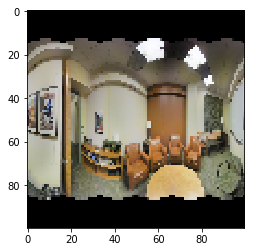

In [4]:
import torchvision.transforms.functional as tfun

path = 'C:/Users/ustundag/Desktop/test_pano_rgb.png'
img = Image.open(path)
img = img.resize((100,100))
data = np.asarray(img, dtype=np.float32)
data = tfun.to_tensor(data)
data = data.unsqueeze_(0)
data = data[:,:3,:,:]
print(data.shape)
plt.imshow(img)
plt.show()

In [5]:
images = data.to(DEVICE)

In [6]:
outputs = classifier(images)
print('outputs.shape: ', outputs.shape)

..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 5.pkl.gz... done
load 5.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 27.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 28.pkl.gz... done
load 18.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 29.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 30.pkl.gz... done
load 19.pkl.gz... 

..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


done
load 31.pkl.gz... done
load 20.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 32.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 33.pkl.gz... done
load 21.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 34.pkl.gz... done
load 22.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 4.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


load 35.pkl.gz... done
load 23.pkl.gz... done


..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


outputs.shape:  torch.Size([1, 64, 12, 12, 12])


(12, 12)


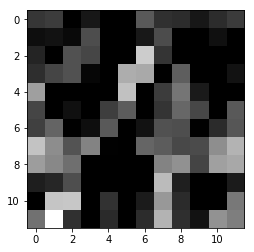

In [7]:
x = outputs.detach().cpu().numpy()
a = x[0, 0, 3, :,:]
print(a.shape)
plt.imshow(a, cmap='gray')
plt.show()

In [8]:
x[0, 0, 0, :, 0]

array([2.419766  , 2.7708275 , 2.5076265 , 2.5360627 , 3.619214  ,
       0.        , 0.24604315, 0.42567158, 0.        , 1.535733  ,
       0.        , 1.8085897 ], dtype=float32)